In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [8]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [12]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
#Self-check: List the Columns in Measurement class
Base.classes.measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [16]:
#Self-check: List the Columns in Station class
Base.classes.station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [18]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
#from alchemy.orm import Session
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [23]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print("The most recent date in the data set is: ", most_recent_date)


The most recent date in the data set is:  2017-08-23


In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Convert most_recent_date to a datetime object
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the date one year from the last date in data set
year_later = most_recent_date + pd.DateOffset(years=1)

print("One year later from the most recent date in the data set is: ", year_later)


One year later from the most recent date in the data set is:  2018-08-23 00:00:00


In [27]:
# Perform a query to retrieve the data and precipitation scores
prcp_date_data = session.query(Measurement.date, Measurement.prcp).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_prcp_date_data = pd.DataFrame(prcp_date_data, columns=['Date', 'Precipitation'])

# Remove NaN values
df_prcp_date_data = df_prcp_date_data.dropna(how='any') 

# Set index as the Date
df_prcp_date_data = df_prcp_date_data.set_index("Date")

# Sort the dataframe by date
df_prcp_date_data = df_prcp_date_data.sort_values(["Date"], ascending=True)

# Print df results
df_prcp_date_data.head(10)

,Precipitation
Date,
2010-01-01,0.08
2010-01-01,0.15
2010-01-01,0.28
2010-01-01,0.05
2010-01-01,0.14
2010-01-01,0.15
2010-01-01,0.21
2010-01-02,0.00
2010-01-02,0.00


Text(0, 0.5, 'Inches')

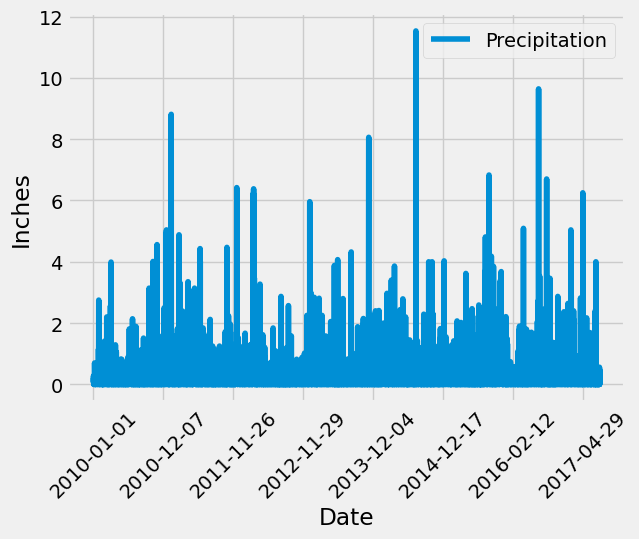

In [29]:
# Use Pandas Plotting with Matplotlib to plot the data
df_prcp_date_data.plot(rot=45)
plt.xlabel("Date")
plt.ylabel("Inches")

In [31]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_prcp_date_data.describe()

,Precipitation
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


# Exploratory Station Analysis

In [34]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.id).count()
print("The total number of stations in the dataset is: ", total_stations)

The total number of stations in the dataset is:  9


In [36]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Query Station & ID, GroupBy Station, OrderBy Measurement ID in Descending order
most_active_stations = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [38]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Based on previous query, most active station is 'USC00519281'
most_active_station_number = 'USC00519281'
temp_data = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station_number).all()
temp_data

[(54.0, 85.0, 71.66378066378067)]

In [40]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Note:
#   The most active station is 'USC00519281'
#   The most recent date in the data set is:  2017-08-23

# Get the last 12 months of data:
station_id = 'USC00519281'
end_date = '2017-08-23'
start_date = '2016-08-24'

last12_temp_observe = session.query(Measurement.tobs).filter(
                        Measurement.station == station_id,
                        Measurement.date >= start_date,
                        Measurement.date <= end_date).all()

# Convert to a Pandas dataframe
last12_temp_observe_df = pd.DataFrame(last12_temp_observe, columns=['TOBS'])
last12_temp_observe_df

,TOBS
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0
...,...
346,77.0
347,77.0
348,76.0
349,76.0


<Axes: ylabel='Frequency'>

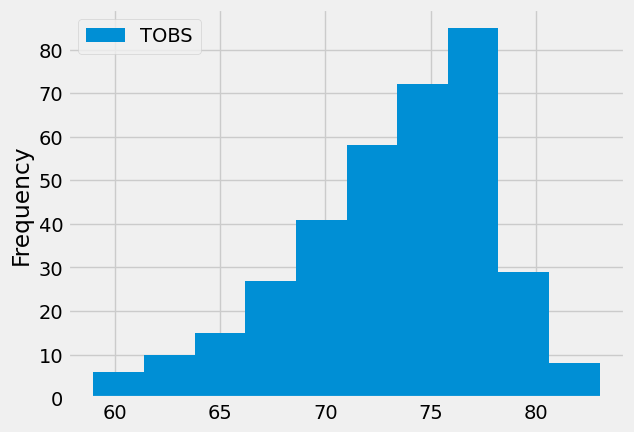

In [42]:
# Graph as histogram
last12_temp_observe_df.plot.hist()

# Close Session

In [45]:
# Close Session
session.close()